In [1]:
import os
import json

from pathlib import Path
from datetime import datetime

import pytz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import matplotlib.patches as mpatches


webMsms_dir = "../webMsms"

plt.rc("text", usetex=True)
rcParams["font.family"] = "CMU Sans Serif"
rcParams["font.size"] = 10

cols = plt.get_cmap("tab10").colors

country_mapping = {
    "Lusaka-NBO": "ZM (NBO PoP)",
    "Lusaka-JNB": "ZM (JNB PoP)",
    "Accra": "GH (LOS PoP)",
    "Berlin": "DE (FRA PoP)",
    "Vancouver": "CA (SEA PoP)",
    "Calgary": "CA (YYC PoP)",
    "Toronto": "CA (YUL PoP)",
}
unique_cities = ["Lusaka", "Accra", "Berlin", "Vancouver", "Calgary", "Toronto"]



In [2]:
def parse_allinone(filename: str):
    data = json.load(open(filename, "r"))
    timestamps = filename.split("_")[-1].split(".")[0]
    timestamps = datetime.strptime(timestamps, "%Y%m%dT%H%M%SZ").replace(
        tzinfo=pytz.UTC
    )
    user_details = data["user_details"]
    city = user_details["City"]
    country = user_details["Country"]
    cache_result = []
    for domain, result in data["web_measurements"].items():
        dns_results = result["dns"]
        dns_result_q_default = float(dns_results["Default"]["query_time"]) / 1000

        if "Google" in dns_results:
            dns_result_q_google = float(dns_results["Google"]["query_time"]) / 1000
        else:
            dns_result_q_google = None

        if "Quad9" in dns_results:
            dns_result_q_quad9 = float(dns_results["Quad9"]["query_time"]) / 1000
        else:
            dns_result_q_quad9 = None

        if "Cloudflare" in dns_results:
            dns_result_q_cloudflare = (
                float(dns_results["Cloudflare"]["query_time"]) / 1000
            )

        else:
            dns_result_q_cloudflare = None
        curl_results = result["curl"]
        for ip, curl_resp in curl_results.items():
            initconnect_time = curl_resp.get("initconnect_time")
            appconnect_time = curl_resp.get("appconnect_time")
            pretransfer_time = curl_resp.get("pretransfer_time")
            redirect_time = curl_resp.get("redirect_time")
            starttransfer_time = curl_resp.get("starttransfer_time")
            total_time = curl_resp.get("total_time")
            cdn_server_id_key = curl_resp.get("cdn_server_id_key")
            cdn_server_id_value = curl_resp.get("cdn_server_id_value")
            cf_cache_status = curl_resp.get("cf_cache_status")
            x_cache = curl_resp.get("x_cache")
            x_cache_remote = curl_resp.get("x_cache_remote")

            r = {
                "domain": domain,
                "timestamp": timestamps,
                "ip": ip,
                "city": city,
                "country": country,
                "initconnect_time": initconnect_time,
                "appconnect_time": appconnect_time,
                "pretransfer_time": pretransfer_time,
                "redirect_time": redirect_time,
                "starttransfer_time": starttransfer_time,
                "total_time": total_time,
                "cdn_server_id_key": cdn_server_id_key,
                "cdn_server_id_value": cdn_server_id_value,
                "cf_cache_status": cf_cache_status,
                "x_cache": x_cache,
                "x_cache_remote": x_cache_remote,
                "dns_query_time_default": dns_result_q_default,
                "dns_query_time_google": dns_result_q_google,
                "dns_query_time_quad9": dns_result_q_quad9,
                "dns_query_time_cloudflare": dns_result_q_cloudflare,
                "overall_total_time": total_time + dns_result_q_default,
            }
            cache_result.append(r)
            break
    return cache_result, timestamps

In [3]:
def parse_to_df() -> pd.DataFrame:
    filename = []
    path = Path(webMsms_dir)
    for dirpath, _, files in os.walk(path):
        if len(files) != 0:
            for f in files:
                if f.endswith(".json"):
                    filename.append(Path(dirpath).joinpath(f))

    results = []
    for i in range(len(filename)):
        per_file_results, timestamp = parse_allinone(str(filename[i]))
        if per_file_results is None:
            continue

        for j in range(len(per_file_results)):
            country = per_file_results[j]["country"]
            city = per_file_results[j]["city"]
            if country in ["US", "CH"]:
                continue
            if city not in unique_cities:
                continue

            if city == "Lusaka":
                if timestamp < datetime(2025, 4, 1, tzinfo=pytz.UTC):
                    city = "Lusaka-NBO"
                else:
                    city = "Lusaka-JNB"
                per_file_results[j]["city"] = city

            results.append(per_file_results[j])

    df = pd.DataFrame(results)
    df = df.sort_values(
        by=["city", "country", "timestamp", "cdn_server_id_key", "domain"]
    )
    return df

In [4]:
def component_plot(df: pd.DataFrame):
    df = df[df["cdn_server_id_key"] == "cf-ray"].copy()

    for col in ["total_time", "starttransfer_time"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["total_time", "starttransfer_time"])

    summary = (
        df.groupby("city")[["total_time", "starttransfer_time"]]
        .mean()
        .rename(
            columns={
                "total_time": "mean_total_time",
                "starttransfer_time": "mean_starttransfer_time",
            }
        )
        .reset_index()
    )

    summary.to_csv("cf_ray_city_ttfb_summary.csv", index=False)
    print("Cloudflare (cf-ray) mean total_time and starttransfer_time by country:")
    print(summary)

    ordered = [
        "Vancouver",
        "Lusaka-NBO",
        "Lusaka-JNB",
        "Accra",
        "Berlin",
        "Calgary",
        "Toronto",
    ]
    summary = summary[summary["city"].isin(ordered)].copy()
    summary["city"] = pd.Categorical(summary["city"], categories=ordered, ordered=True)
    summary = summary.sort_values("city")

    if summary.empty:
        return

    start_vals = summary["mean_starttransfer_time"].values
    total_vals = summary["mean_total_time"].values
    remaining = (total_vals - start_vals).clip(min=0)

    fig, ax = plt.subplots(figsize=(4.66, 2))
    y = summary["city"].values

    ax.barh(
        y, start_vals, color=cols[1], edgecolor="black", label="Start Transfer (TTFB)"
    )
    ax.barh(
        y,
        remaining,
        left=start_vals,
        color=cols[0],
        edgecolor="black",
        label="Remaining Transfer",
    )

    for yt, s, r in zip(y, start_vals, remaining):
        ax.text(s + r + 0.01, yt, f"{s + r:.2f}s", va="center", fontsize=8)

    ax.set_yticks(y)
    ax.set_yticklabels([country_mapping.get(c, c) for c in y])
    ax.set_xlabel("Total Page Fetch Time [s]")
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.set_xlim(0, max(total_vals) * 1.15)

    ax.legend(
        loc="best",
        fontsize="small",
        edgecolor="k",
        handlelength=1,
        labelspacing=0.06,
        columnspacing=0.5,
        handletextpad=0.3,
        fancybox=False,
    )
    plt.tight_layout()
    plt.savefig("cf_ray_city_ttfb_bar.png", dpi=300)
    plt.savefig("cf_ray_city_ttfb_bar.pdf", dpi=300)
    plt.show()

In [5]:
df = parse_to_df()
df.head()

,domain,timestamp,ip,city,country,initconnect_time,appconnect_time,pretransfer_time,redirect_time,starttransfer_time,...,cdn_server_id_key,cdn_server_id_value,cf_cache_status,x_cache,x_cache_remote,dns_query_time_default,dns_query_time_google,dns_query_time_quad9,dns_query_time_cloudflare,overall_total_time
92184,www.apple.com,2025-03-02 03:11:16+00:00,184.25.233.54,Accra,GH,0.108071,0.239540,0.240233,0.0,0.358376,...,,,,,None,0.004,0.032,0.112,0.096,0.362456
92185,www.bing.com,2025-03-02 03:11:16+00:00,23.62.180.198,Accra,GH,0.153157,0.331064,0.331688,0.0,0.646348,...,,,,,None,0.004,0.112,0.112,0.088,0.650461
92190,www.cisco.com,2025-03-02 03:11:16+00:00,2.17.153.67,Accra,GH,0.194863,0.605194,0.606216,0.0,0.815065,...,,,,,None,1.216,0.204,0.528,0.088,2.031132
92186,www.icloud.com,2025-03-02 03:11:16+00:00,184.24.2.246,Accra,GH,0.159371,0.333377,0.334225,0.0,0.500928,...,,,,,None,0.876,0.024,0.092,0.092,1.377016
92187,www.intuit.com,2025-03-02 03:11:16+00:00,23.42.8.217,Accra,GH,0.112347,0.336596,0.336954,0.0,0.624279,...,,,,,None,0.560,0.208,0.128,0.100,1.184365


Cloudflare (cf-ray) mean total_time and starttransfer_time by country:
         city  mean_total_time  mean_starttransfer_time
0       Accra         0.635651                 0.593655
1      Berlin         0.210423                 0.203316
2     Calgary         0.300145                 0.289593
3  Lusaka-JNB         0.470254                 0.396325
4  Lusaka-NBO         1.099761                 0.796953
5     Toronto         0.283607                 0.267259
6   Vancouver         0.242072                 0.217182


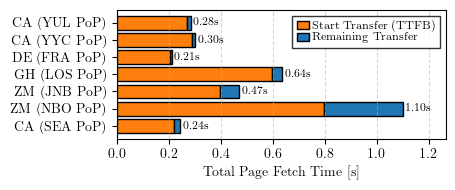

In [6]:
component_plot(df)